In [7]:
pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch as th
import numpy as np
import random

#сделаем инициализацию random seed, 
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [2]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/Users/katy/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/katy/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/katy/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/katy/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [6]:
#посмотрим на размерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

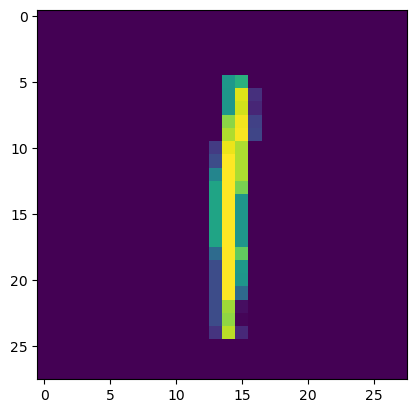

tensor(1)


In [8]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[454, :, :])
plt.show()
print(y_train[454])

In [9]:
#Создание сети
# на выходе у нас числа от 0 до 9
import torch.nn as nn
import torch.optim as optim


class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = nn.Linear(784, 128) #28x28
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
    self.leaky_relu = nn.LeakyReLU(0.01)

  def forward(self, x):
    x = x.view(x.shape[0], -1) #преобразование входных изображений в матрицы
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def predict(self, x):
    with th.no_grad():
        x = x.to(device)
        output = self(x) # Вероятность каждого класса
        _, predicted = th.max(output, 1)
    return predicted



In [10]:
''' есть ли видеокарта?'''
th.cuda.is_available()

False

In [11]:
'''смотрим, занята ли карта какими либо вычислениями'''
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [17]:
""" теперь нужно переложить вычисления на видеокарту"""

device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
model = MNISTnet().to(device)


In [13]:
# определение лосс-функции
criterion = nn.CrossEntropyLoss().to(device)

# определение оптимизатора
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [15]:
batch_size = 100
epochs = 10

'''перекладываем входные данные теста на видеокарту'''
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

train_losses, test_losses = [], []

'''данные тренировочной выборки будем перекладывать на cuda по батчам'''
for epoch in range(epochs):
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
     end_index = start_index + batch_size
     batch_indexes = order[start_index:end_index]
     X_batch = X_train[batch_indexes]
     y_batch = y_train[batch_indexes]
     optimizer.zero_grad()
     y_pred = model.forward(X_batch)
     loss = criterion(y_pred, y_batch)
     loss.backward()
     optimizer.step()
     
  test_accuracy = th.mean((model.predict(X_test) == y_test).float())
  print('Epoch:', epoch, 'Test accuracy:', test_accuracy.item())
  train_losses.append(loss.item())



Epoch: 0 Test accuracy: 0.9696999788284302
Epoch: 1 Test accuracy: 0.9690999984741211
Epoch: 2 Test accuracy: 0.9692999720573425
Epoch: 3 Test accuracy: 0.9693999886512756
Epoch: 4 Test accuracy: 0.9699000120162964
Epoch: 5 Test accuracy: 0.9690999984741211
Epoch: 6 Test accuracy: 0.9690999984741211
Epoch: 7 Test accuracy: 0.9692999720573425
Epoch: 8 Test accuracy: 0.9692999720573425
Epoch: 9 Test accuracy: 0.9696000218391418


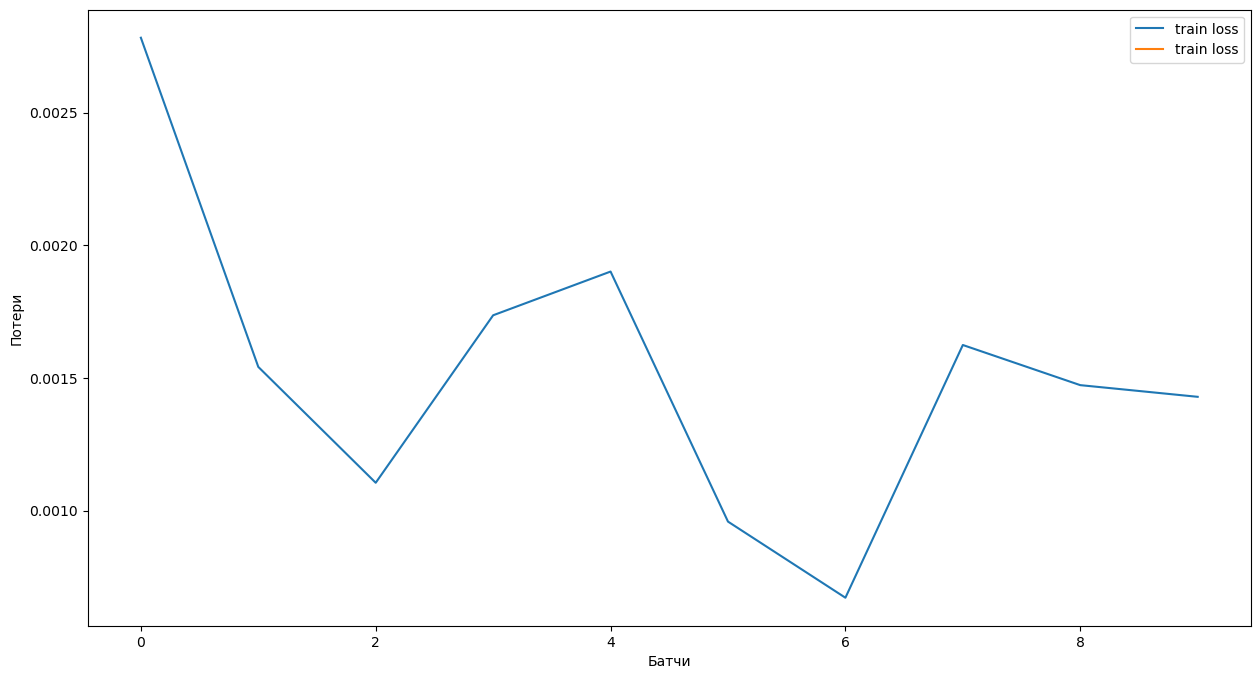

In [16]:
#график loss для тестовой и обучающей выборок
plt.figure(figsize = (15, 8))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='train loss')
plt.ylabel("Потери")
plt.xlabel("Батчи")
plt.legend()
plt.show()

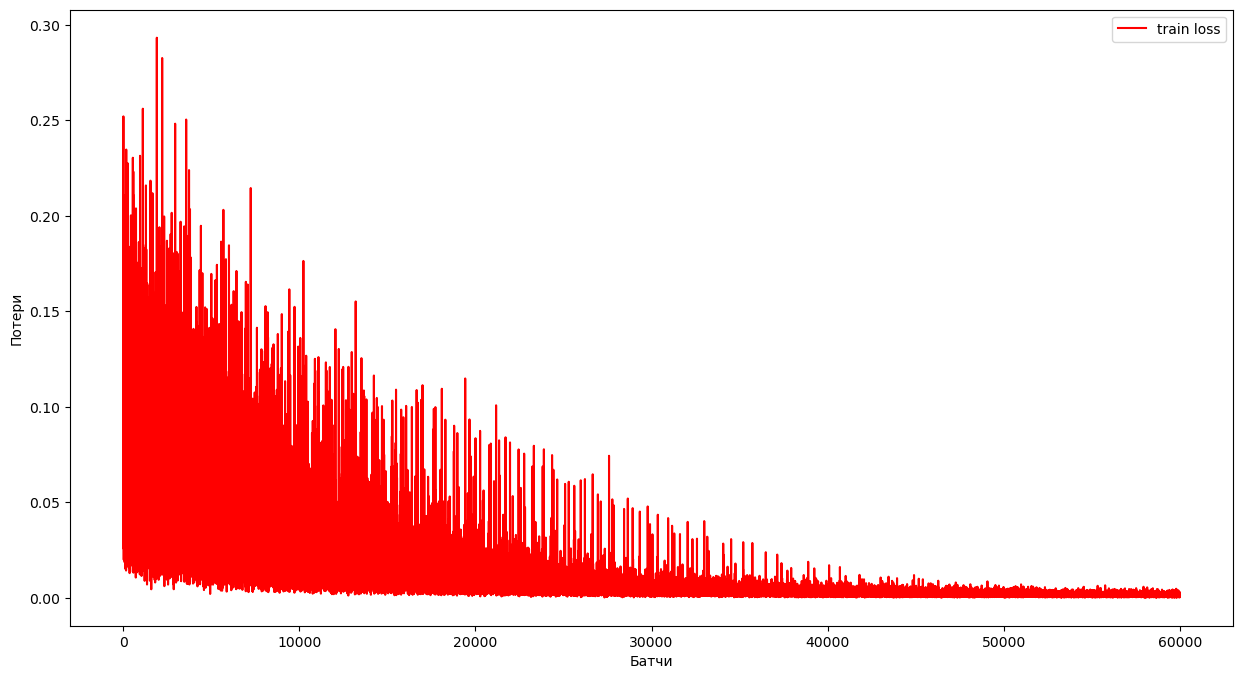

In [52]:
#график loss для тестовой и обучающей выборок
plt.figure(figsize = (15, 8))
plt.plot(train_losses, label='train loss', color = 'red')
plt.ylabel("Потери")
plt.xlabel("Батчи")
plt.legend()
plt.show()

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь.
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации.
4.   Построить на одном графике loss для тестовой выборки и для обучающей.
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
6.   Замерьте время вычисления 100 эпох на CPU и на GPU.
7.   Показать результат работы модели с использованием функции predict.


In [40]:
import pandas as pd

In [46]:
lst = model.predict(X_test).tolist() #сбалансированность
pred_df = pd.Series(lst)
pred_df.value_counts()

1    1143
3    1071
2    1055
7    1004
9     992
4     987
0     982
6     962
8     914
5     890
dtype: int64

tensor(8)


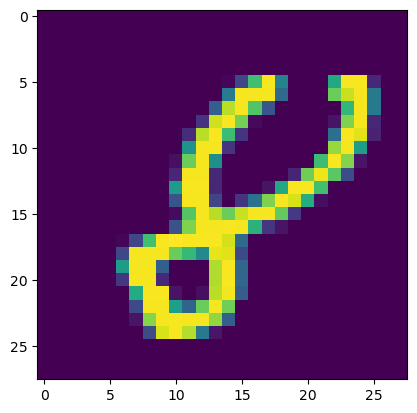

tensor(8)

In [16]:
n = 8236
print(y_test[n])
plt.imshow(X_test[n, :, :])
plt.show()
pred = model.predict(X_test)
pred[n]